In [2]:
import scipy.interpolate as interp
from scipy.signal import savgol_filter
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import itertools
import pickle
import pandas as pd
import seaborn as sns
import anipose_scripts.anipose_main as main
import anipose_scripts.constants as constants
import tools
import pprint
import itertools
import os
from analysis import *

plt.rcParams['figure.facecolor'] = 'white'

Moviepy - Building video concat.mp4.
Moviepy - Writing video concat.mp4

Moviepy - Done !
Moviepy - video ready concat.mp4


In [13]:
FILTER_WINDOW_MS = 125
FILTER_WINDOW_FRAMES = FILTER_WINDOW_MS * FRAME_RATE // 1000

def compute_angles(a, b, c, degrees=True):
    '''Computes angles between 3 point arrays of shape [points, coordinates]'''
    ba = b - a
    bc = b - c
    dp = np.diagonal(np.dot(ba, bc.T))
    cosine_angle = dp / (np.linalg.norm(ba, axis=1) * np.linalg.norm(bc, axis=1))
    angle = np.arccos(cosine_angle)
    if degrees:
        angle = np.degrees(angle)
    return angle

def interpolate_polyline(polyline, num_points):
    # tck, u = interp.splprep(polyline.T, s=INTERP_SMOOTH_MOTION_COEFFICIENT)
    tck, u = interp.splprep(polyline.T, s=10)
    u = np.linspace(0.0, 1.0, num_points)
    return interp.splev(u, tck)

### LOOP OVER THIS
from collections import defaultdict
dd = defaultdict(list)
marker_regions = marker_regions_per_video[0]
for cam in [0, 1]:
    for k, regions in marker_regions[cam].items():
        for region_ix, region in enumerate(regions):
            bps = BPS_CARE[k]
            bps_ix = [bp_dict[bp] for bp in bps]
            x = marker_xys[cam][bps_ix, region[0]:region[1], 0]
            y = marker_xys[cam][bps_ix, region[0]:region[1], 1]

            x_av = np.mean(x, axis=0)
            y_av = np.mean(y, axis=0)
            x_itp, y_itp = interpolate_polyline(np.array([x_av, y_av]).T, len(x_av))
            x_velocity = np.diff(x_itp)
            x_velocity = np.hstack((x_velocity[0], x_velocity))
            y_velocity = np.diff(y_itp)
            y_velocity = np.hstack((y_velocity[0], y_velocity))

            angles = []
            for paw_bps in BPS_ANGLES[k]:
                angle_ixs = [bp_dict[bp] for bp in paw_bps]
                angle_coors = marker_xys[cam][angle_ixs, region[0]:region[1],
                              :2]
                angles.append(compute_angles(angle_coors[0],
                                             angle_coors[1],
                                             angle_coors[2]))
            if len(angles):
                angles = np.mean(angles, axis=0)
                angles_smoothed=savgol_filter(angles,
                                              window_length=FILTER_WINDOW_FRAMES,
                                              polyorder=0)
                angles_v = np.diff(angles_smoothed)
                angles_v = np.hstack((angles_v[0], angles_v))
                angles_v=savgol_filter(angles_v,
                                              window_length=FILTER_WINDOW_FRAMES,
                                              polyorder=0)

                angles_a = np.diff(angles_v)
                angles_a = np.hstack((angles_a[0], angles_a))
                # angles_v=savgol_filter(angles_v,
                #                               window_length=FILTER_WINDOW_FRAMES,
                #                               polyorder=0)
            else:
                angles = []
                angles_smoothed=[]
                angles_v = []
                angles_a = []


            dd['camera'].append(cam)
            dd['experiment'].append(k)
            dd['bps'].append(bps)
            dd['region_ix'].append(region_ix)
            dd['region'].append(region)
            dd['xp'].append(x_av)
            dd['yp'].append(y_av)
            dd['xitp'].append(x_itp)
            dd['yitp'].append(y_itp)
            dd['xv'].append(x_velocity)
            dd['yv'].append(y_velocity)
            dd['ap'].append(angles)
            dd['aitp'].append(angles_smoothed)
            dd['av'].append(angles_v)
            dd['aa'].append(angles_a)

df = pd.DataFrame(dd)
df.head()

,camera,experiment,bps,region_ix,region,xp,yp,xitp,yitp,xv,yv,ap,aitp,av,aa
0,0,location,"[r2_in, r3_in]",0,"[0, 1362]","[197.48735809326172, 197.23240661621094, 197.1...","[87.59857940673828, 87.35967636108398, 87.5290...","[197.48781948965717, 197.3178564271041, 197.16...","[87.59499478911395, 87.33362120389744, 87.4566...","[-0.16996306255308014, -0.16996306255308014, -...","[-0.26137358521651777, -0.26137358521651777, 0...","[93.1807185147454, 91.83477039414291, 90.83842...","[92.52709660926712, 92.52709660926712, 92.5270...","[0.06441559593229158, 0.06441559593229158, 0.0...","[0.0, 0.0, -1.3877787807814457e-17, 0.09581126..."
1,0,location,"[r2_in, r3_in]",1,"[1418, 1600]","[197.11984252929688, 197.1650619506836, 197.24...","[87.16648483276367, 87.12472915649414, 87.1937...","[197.19539816616467, 197.1947175424559, 197.19...","[87.18370546752557, 87.18544143428886, 87.1871...","[-0.0006806237087744194, -0.000680623708774419...","[0.0017359667632916853, 0.0017359667632916853,...","[91.03588518392232, 90.83868948452019, 90.8874...","[90.98728505802269, 90.98728505802269, 90.9872...","[-0.0024783754922452776, -0.002478375492245277...","[0.0, 0.0, 4.336808689942018e-19, 0.0111101770..."
2,0,paw,"[r1_in, r1_out, r2_in, r2_out, r3_in, r3_out, ...",0,"[0, 1361]","[197.97021675109863, 197.7529067993164, 197.80...","[89.24113941192627, 88.973388671875, 89.138649...","[197.96847453600333, 197.8256410164234, 197.75...","[89.23752740645863, 89.01945063495215, 89.0508...","[-0.14283351957993773, -0.14283351957993773, -...","[-0.21807677150647464, -0.21807677150647464, 0...","[93.55997588174178, 93.06381348931397, 93.4398...","[93.42818554762286, 93.42818554762286, 93.4281...","[0.02209652958658239, 0.02209652958658239, 0.0...","[0.0, 0.0, 0.0, 0.005846104095593319, -0.00216..."
3,0,paw,"[r1_in, r1_out, r2_in, r2_out, r3_in, r3_out, ...",1,"[1418, 1494]","[197.63018035888672, 197.70695686340332, 197.8...","[89.07569026947021, 89.07324028015137, 89.1090...","[197.72059227662595, 197.716767662421, 197.713...","[89.10102199864306, 89.1038487907622, 89.10668...","[-0.0038246142049445098, -0.003824614204944509...","[0.002826792119137167, 0.002826792119137167, 0...","[95.32639558506906, 95.05511338541721, 95.2968...","[95.18647971850638, 95.18647971850638, 95.1864...","[-0.001437505087022828, -0.001437505087022828,...","[0.0, 0.0, 2.168404344971009e-19, 0.0033638515..."
4,0,paw,"[r1_in, r1_out, r2_in, r2_out, r3_in, r3_out, ...",2,"[1498, 1600]","[197.77474403381348, 197.75, 197.5369205474853...","[89.21258640289307, 89.18599891662598, 88.9457...","[197.6407970170944, 197.64067424990742, 197.64...","[89.11754645941886, 89.12070269382787, 89.1237...","[-0.00012276718697989963, -0.00012276718697989...","[0.00315623440900481, 0.00315623440900481, 0.0...","[95.21373891596822, 94.930196778234, 95.241919...","[95.16338825840012, 95.16338825840012, 95.1633...","[0.011178021576495212, 0.011178021576495212, 0...","[0.0, 0.0, -1.734723475976807e-18, 4.442428547..."


In [24]:
# # GET GRAB COORDINATES
#
# THRESHOLD_PIXELS_PER_SECOND = 40
# THRESHOLD_PIXELS_PER_FRAME = THRESHOLD_PIXELS_PER_SECOND / FRAME_RATE
# THRESHOLD_DURATION_MS = 250
# THRESHOLD_DURATION_FRAMES = THRESHOLD_DURATION_MS * FRAME_RATE // 1000
#
# # GET REACHS
# vec = df.query("camera==1 & experiment=='location'")
# all_forward_reaches = []
# maximal_extensions = []
# for i in range(len(vec)):
#     region = vec['region'].iloc[i]
#     x_p = vec['xp'].iloc[i]
#     x_v = vec['xv'].iloc[i]
#     y_v = vec['yv'].iloc[i]
#     a_p = vec['ap'].iloc[i]
#
#     reach_regions, _ = find_region_bounds(
#         bool_array=x_v > THRESHOLD_PIXELS_PER_FRAME,
#         min_gap=THRESHOLD_DURATION_FRAMES)
#     retract_regions, _ = find_region_bounds(
#         bool_array=x_v < -THRESHOLD_PIXELS_PER_FRAME,
#         min_gap=THRESHOLD_DURATION_FRAMES
#     )
#     all_forward_reaches.append(reach_regions + region[0])
#     for r in reach_regions:
#         ix = region[0] + r[0] + np.argmax(x_p[r[0]:r[1]+20])
#         maximal_extensions.append(ix)

array([192.55292511, 192.80405426, 192.39638519, 192.07868195,
       192.38924408, 192.31895447, 192.77661896, 193.06903839,
       192.65401459, 192.59732819, 192.49310303, 193.19374084,
       192.81915283, 192.41271973, 192.86936188, 192.67780304,
       192.37225342, 192.05239105, 192.86186981, 193.21498108,
       192.51898193, 192.61101532, 192.11940002, 192.141922  ,
       192.19303131, 192.64472198, 192.56401062, 192.44528961,
       192.6955719 , 192.32791901, 192.68504333, 192.32504272,
       192.33630371, 192.77591705, 192.46875   , 192.15533447,
       192.65913391, 192.2673645 , 192.43632507, 193.14073944,
       192.71382904, 192.85630035, 191.91497803, 192.48770905,
       192.86921692, 192.45979309, 192.19688416, 192.28301239,
       192.06815338, 192.06852722, 192.12181091, 192.5304718 ,
       192.36618805, 192.6346817 , 192.44295502, 192.3562088 ,
       192.75915527, 191.98564911, 192.22824097, 192.64910126,
       192.5355835 , 192.58394623, 192.27745056, 192.38

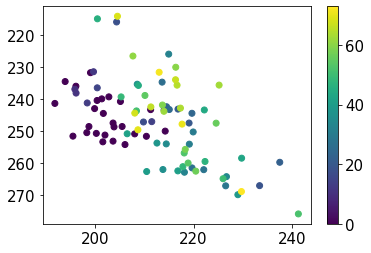

In [38]:
all_grab_xy = np.array([x for y in grab_xy_per_video for x in y])
c = np.zeros(len(all_grab_xy))
c[:25] = 0
c[25:] = np.arange(10, 10+len(c[25:]))
plt.scatter(all_grab_xy[:,0], all_grab_xy[:, 1], c=c)
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()

In [44]:
SCORE_THRESHOLD = 0.99
bp_ixs = [bp_dict[bp] for bp in BPS_TRACK_PELLET]

for i, marker_xys in enumerate(marker_xys_per_video):
    data = marker_xys[1]
    regions, region_ixs = get_good_chunks(data,
                                          bp_ixs,
                                          score_threshold=SCORE_THRESHOLD,
                                          min_frames=3)


    x = data[bp_ixs, :, 0]
    y = data[bp_ixs, :, 1]
    score = data[bp_ixs, :, 2]
    bool_mask = np.ones_like(score)
    bool_mask[:, region_ixs] = 0

    # x = savgol_filter(x, window_length=3, polyorder=0)
    # y = savgol_filter(y, window_length=3, polyorder=0)
    x = np.ma.masked_where(bool_mask, x).flatten()
    y = np.ma.masked_where(bool_mask, y).flatten()

    outcome = []
    final_outcome = None
    if not np.any(score[0, :50] > SCORE_THRESHOLD):
        outcome.append([0, 'no pellet dispensed'])

    if np.sum(y < 120):
        ix = np.argwhere(y < 120)[0][0]
        outcome.append([ix, 'success'])

    if np.any(x > 270):
        ix = np.argwhere(x > 270)[0][0]
        outcome.append([ix, 'drop'])

    if np.any(y > 180):
        ix = np.argwhere(y > 180)[0][0]
        outcome.append([ix, 'drop'])

    if np.mean(score[-50:] > SCORE_THRESHOLD) > 0.8:
        ix = len(score)
        outcome.append([ix, 'pellet still present'])

    if len(outcome) == 0:
        final_outcome = 'success by exclusion'
    else:
        outcome.sort(key = lambda x: x[0])
        final_outcome = outcome[0][1]

    # outcome = 'wtf'
    # f, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    # axs[0].plot(x.T, '.')
    # # axs[0].set_xlim([0, 50])
    # plt.title(i)
    # axs[1].plot(y.T, '.')
    # # axs[1].set_xlim([0, 50])
    # plt.title(i)
    # axs[2].plot(score[:, :50].T, '.')
    # # axs[2].set_xlim([0, 50])

    print(i, outcome, final_outcome)

# data = marker_xys_per_video[2][1]
# regions, region_ixs = get_good_chunks(data,
#                                       bp_ixs,
#                                       score_threshold=SCORE_THRESHOLD,
#                                       min_frames=3)
# x = data[bp_ixs, :, 0]
# y = data[bp_ixs, :, 1]
# # x = savgol_filter(x, window_length=3, polyorder=0)
# # y = savgol_filter(y, window_length=3, polyorder=0)
# score = data[bp_ixs, :, 2]
# bool_mask = np.ones_like(score)
# bool_mask[:, region_ixs] = 0
# x = np.ma.masked_where(bool_mask, x)
# y = np.ma.masked_where(bool_mask, y)
#
#
# size = [10, 3]
# ylim_v = [-10, 10]
# plt.figure(figsize=size)
# plt.plot(x.T, '.', markersize=2)
# plt.xlim([0, data.shape[1]])
# plt.legend(BPS_TRACK_PELLET, frameon=False, loc='upper right')
# sns.despine()
#
# plt.figure(figsize=size)
# plt.plot(y.T, '.', markersize=2)
# plt.xlim([0, data.shape[1]])
# plt.legend(BPS_TRACK_PELLET, frameon=False, loc='upper right')
# sns.despine()



0 [[116, 'success']] success
1 [[170, 'success']] success
2 [[0, 'no pellet dispensed']] no pellet dispensed
3 [[332, 'success']] success
4 [[118, 'success']] success
5 [[165, 'success']] success
6 [[202, 'success']] success
7 [] success by exclusion
8 [[186, 'drop']] drop
9 [[128, 'success'], [1110, 'drop']] success
10 [[141, 'success']] success
11 [[100, 'success']] success
12 [[344, 'success']] success
13 [[172, 'success']] success
14 [[100, 'drop']] drop
15 [[122, 'drop'], [188, 'success']] drop
16 [[87, 'success']] success
17 [[126, 'success'], [207, 'drop']] success
18 [[481, 'success']] success
19 [[289, 'success']] success
20 [[798, 'success']] success
21 [[1507, 'success']] success
22 [[600, 'drop']] drop
23 [[405, 'drop']] drop
24 [[193, 'success']] success
25 [[1, 'pellet still present']] pellet still present
26 [[1, 'pellet still present']] pellet still present
27 [[312, 'success']] success
28 [[274, 'drop']] drop
29 [] success by exclusion
30 [[1, 'pellet still present']] 

(1, 1600)

Text(0, 0.5, 'Velocity (pixels / frames)')

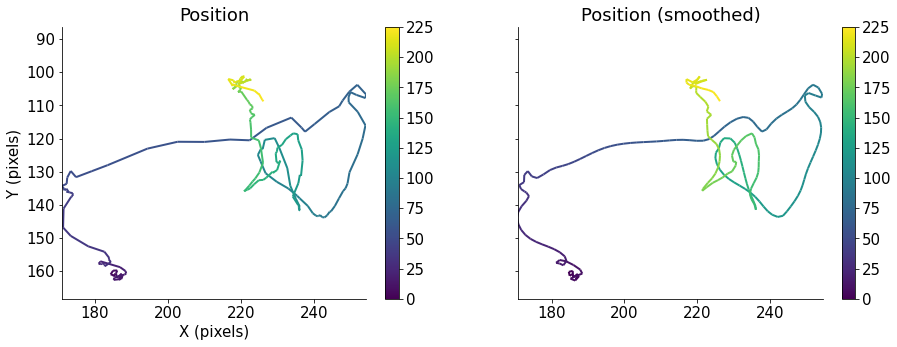

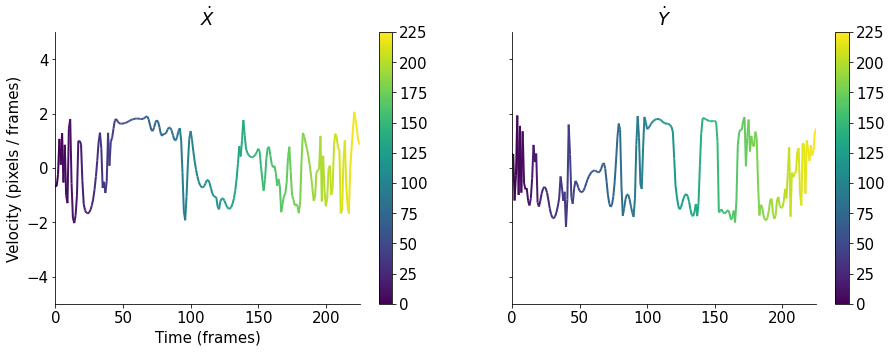

In [57]:
def make_multicolored_line(x, y, plot_args):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    c = np.arange(len(points))
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(c.min(), c.max())
    lc = LineCollection(segments, norm=norm, **plot_args)
    lc.set_array(c)
    lc.set_linewidth(2)
    return lc

def make_plot(x, y, plot_args, title, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    lc = make_multicolored_line(x, y, plot_args)
    line = ax.add_collection(lc)
    plt.colorbar(line, ax=ax)
    ax.set_title(title)
    sns.despine()

vec = df.query("camera=='CAM1' & experiment=='location' & region_ix==0")
region = vec['region'].iloc[0]
x_av = vec['xp'].iloc[0]
y_av = vec['yp'].iloc[0]
x_itp = vec['xitp'].iloc[0]
y_itp = vec['yitp'].iloc[0]
x_v = vec['xv'].iloc[0]
y_v = vec['yv'].iloc[0]

plot_args = {'cmap': 'viridis'}
f, axs = plt.subplots(nrows=1,
                      ncols=2,
                      figsize=(15, 5),
                      sharex=True,
                      sharey=True
                      )

make_plot(x_av, y_av, plot_args, 'Position', ax=axs[0])
make_plot(x_itp, y_itp, plot_args, 'Position (smoothed)', ax=axs[1])
bound = (x_av.max() - x_av.min())//2
axs[0].set_xlim(x_av.min(), x_av.max())
axs[0].set_ylim(y_av.mean() - bound, y_av.mean() + bound)
axs[0].invert_yaxis()
axs[0].set_xlabel('X (pixels)')
axs[0].set_ylabel('Y (pixels)')

f, axs = plt.subplots(nrows=1,
                      ncols=2,
                      figsize=(15, 5),
                      sharex=True,
                      sharey=True
                      )

make_plot(np.arange(region[0], region[1]),
          x_v,
          plot_args,
          r"$\.X$",
          axs[0])

make_plot(np.arange(region[0], region[1]),
          y_v,
          plot_args,
          r"$\.Y$",
          axs[1])
axs[0].set_ylim(-5, 5)
axs[0].set_xlabel('Time (frames)')
axs[0].set_ylabel('Velocity (pixels / frames)')

(0.0, 500.0)

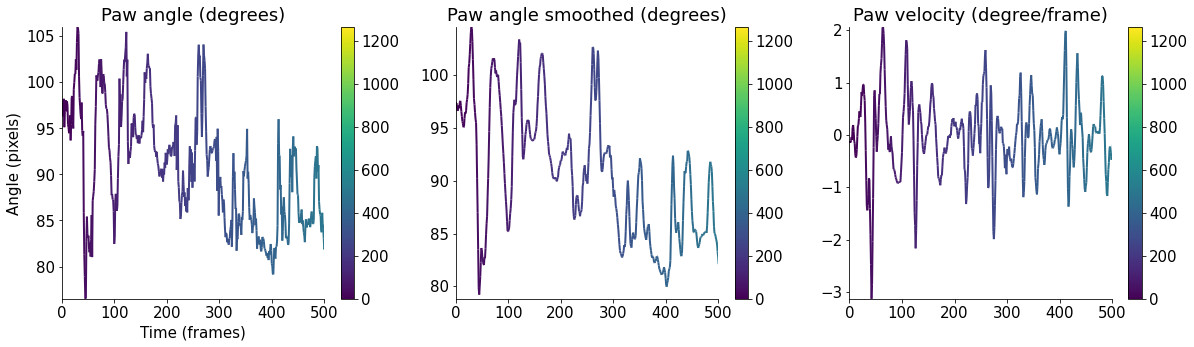

In [58]:
vec = df.query("camera=='CAM0' & experiment=='location' & region_ix==0")
vec.head()
region = vec['region'].iloc[0]
a_p = vec['ap'].iloc[0]
a_itp = vec['aitp'].iloc[0]
a_v = vec['av'].iloc[0]
a_a = vec['aa'].iloc[0]

f, axs = plt.subplots(nrows=1,
                      ncols=3,
                      figsize=(20, 5),
                      )

make_plot(np.arange(region[0], region[1]),
          a_p,
          plot_args,
          r"Paw angle (degrees)",
          axs[0])

make_plot(np.arange(region[0], region[1]),
          a_itp,
          plot_args,
          r"Paw angle smoothed (degrees)",
          axs[1])

make_plot(np.arange(region[0], region[1]),
          a_v,
          plot_args,
          r"Paw velocity (degree/frame)",
          axs[2])

axs[0].set_xlabel('Time (frames)')
axs[0].set_ylabel('Angle (pixels)')

xlim = [0, 500]
axs[0].set_xlim(xlim)
axs[1].set_xlim(xlim)
axs[2].set_xlim(xlim)


In [ ]:
# points = np.array([x_av, y_av]).T
# plot_points = []
# for ix in range(points.shape[0]-trailing):
#     plot_points.append(points[ix:ix+trailing])
#
# from matplotlib import animation
# f = plt.figure(figsize=(5, 3))
# ax = plt.gca()
# ax.set_xlim(x_av.min(), x_av.max())
# ax.set_ylim(y_av.min(), y_av.max())
# ax.invert_yaxis()
# color = np.arange(len(plot_points))
# line, = plt.plot(plot_points[0][:, 0], plot_points[0][:, 1])
#
#
# def animate(i):
#     line.set_data(plot_points[i][:, 0], plot_points[i][:, 1])
#     return line,
#
# anim = animation.FuncAnimation(f,
#                                animate,
#                                frames=len(plot_points),
#                                blit=True)
# anim.save('basic_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
# plt.show()